In [1]:
# !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
# !unzip -q kagglecatsanddogs_3367a.zip
# !ls PetImages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [3]:
image_size = (32, 32)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [4]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [5]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [6]:
def make_model(input_shape, num_classes, dual=False):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        if dual:
            x = layers.concatenate([layers.MaxPooling2D(3, strides=2, padding="same")(x),
                                    layers.AveragePooling2D(3, strides=2, padding="same")(x)])
            residual = layers.Conv2D(size*2, 1, strides=2, padding="same")(
            previous_block_activation
        )
        else:
            x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
            residual = layers.Conv2D(size, 1, strides=2, padding="same")(
                previous_block_activation
        )
        
        
        # Project residual
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)




In [7]:
model = make_model(input_shape=image_size + (3,), num_classes=2, dual=True)
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [8]:
epochs = 50

callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 226s 385ms/step - loss: 0.7006 - accuracy: 0.6111 - val_loss: 0.6161 - val_accuracy: 0.6715
Epoch 2/50
586/586 [==============================] - 222s 378ms/step - loss: 0.5958 - accuracy: 0.6924 - val_loss: 0.8774 - val_accuracy: 0.5681
Epoch 3/50
586/586 [==============================] - 222s 378ms/step - loss: 0.5416 - accuracy: 0.7375 - val_loss: 0.5754 - val_accuracy: 0.7106
Epoch 4/50
586/586 [==============================] - 222s 378ms/step - loss: 0.5156 - accuracy: 0.7537 - val_loss: 0.5129 - val_accuracy: 0.7757
Epoch 5/50
586/586 [==============================] - 221s 378ms/step - loss: 0.4992 - accuracy: 0.7676 - val_loss: 0.4848 - val_accuracy: 0.7631
Epoch 6/50
586/586 [==============================] - 221s 378ms/step - loss: 0.4780 - accuracy: 0.7777 - val_loss: 0.4713 - val_accuracy: 0.7789
Epoch 7/50
586/586 [==============================] - 222s 378ms/step - loss: 0.4639 - accuracy: 0.7863 - val_loss: 0.4580 -

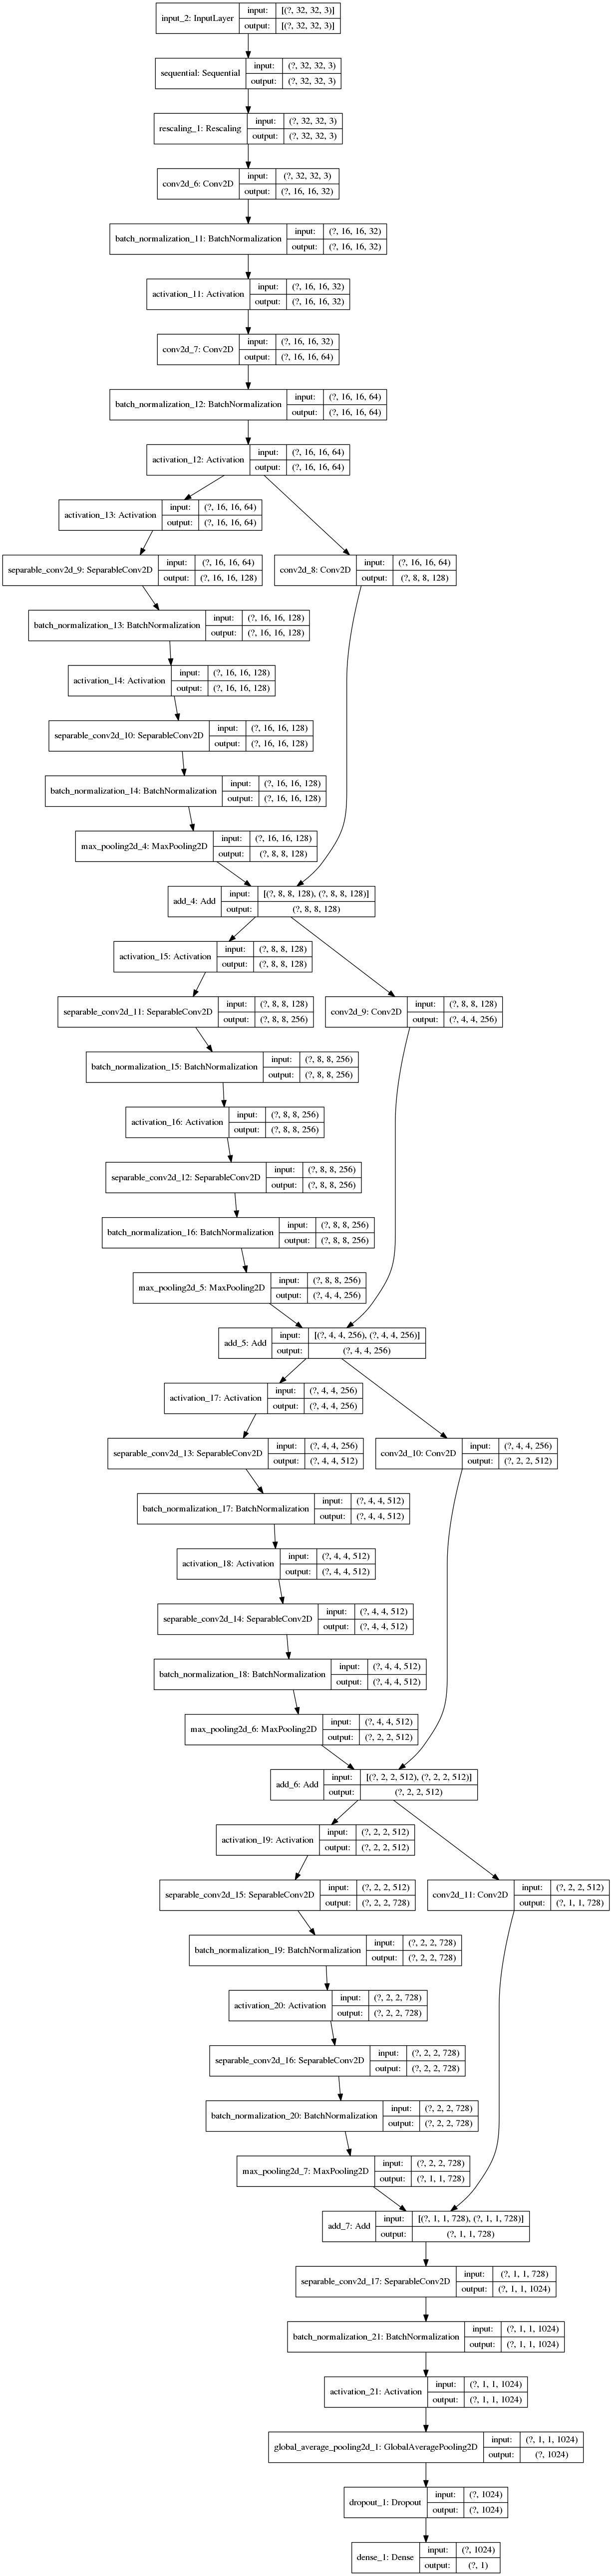

In [9]:
model = make_model(input_shape=image_size + (3,), num_classes=2, dual=False)
keras.utils.plot_model(model, show_shapes=True)

In [10]:
epochs = 50

callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5", =),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 186s 318ms/step - loss: 0.6501 - accuracy: 0.6393 - val_loss: 0.6944 - val_accuracy: 0.5088
Epoch 2/50
586/586 [==============================] - 186s 317ms/step - loss: 0.5724 - accuracy: 0.7069 - val_loss: 0.6436 - val_accuracy: 0.6153
Epoch 3/50
586/586 [==============================] - 186s 318ms/step - loss: 0.5372 - accuracy: 0.7314 - val_loss: 0.5741 - val_accuracy: 0.6837
Epoch 4/50
586/586 [==============================] - 187s 318ms/step - loss: 0.5148 - accuracy: 0.7519 - val_loss: 0.7131 - val_accuracy: 0.5547
Epoch 5/50
586/586 [==============================] - 172s 293ms/step - loss: 0.4983 - accuracy: 0.7615 - val_loss: 0.4908 - val_accuracy: 0.7507
Epoch 6/50
586/586 [==============================] - 129s 220ms/step - loss: 0.4883 - accuracy: 0.7668 - val_loss: 0.4826 - val_accuracy: 0.7710
Epoch 7/50
586/586 [==============================] - 129s 220ms/step - loss: 0.4732 - accuracy: 0.7795 - val_loss: 0.5523 -